**Sythetic Data Geneation Models**

Description: Implements a synthetic data generation pipeline to generate variations of EEG signals using the following methods:

1. Variational Auto Encorder
2. Conditional Variational Auto Encorders


## Import Libraries

In [8]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, Conv1DTranspose, Dropout, Dense, Flatten, Lambda, concatenate, MaxPooling1D, Embedding
from tensorflow.keras import backend as K

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
device = '/device:GPU:0' if gpus else '/device:CPU:0'
print(f"Using device: {device}")

Using device: /device:GPU:0


## Load Data

In [3]:
# Load data
train_data = pd.read_csv('../data/hard_test_cases/train.csv', index_col=0)
test_data = pd.read_csv('../data/hard_test_cases/test.csv', index_col=0)

X_train = train_data.iloc[:, :-1].values  # X1-X178
X_test = test_data.iloc[:, :-1].values    # X1-X178

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for the model
X_train_scaled = X_train_scaled.reshape(-1, 178, 1)
X_test_scaled = X_test_scaled.reshape(-1, 178, 1)

In [4]:
# Reshape the data for the model
X_train = X_train.reshape(-1, 178, 1)

## Vizualize 

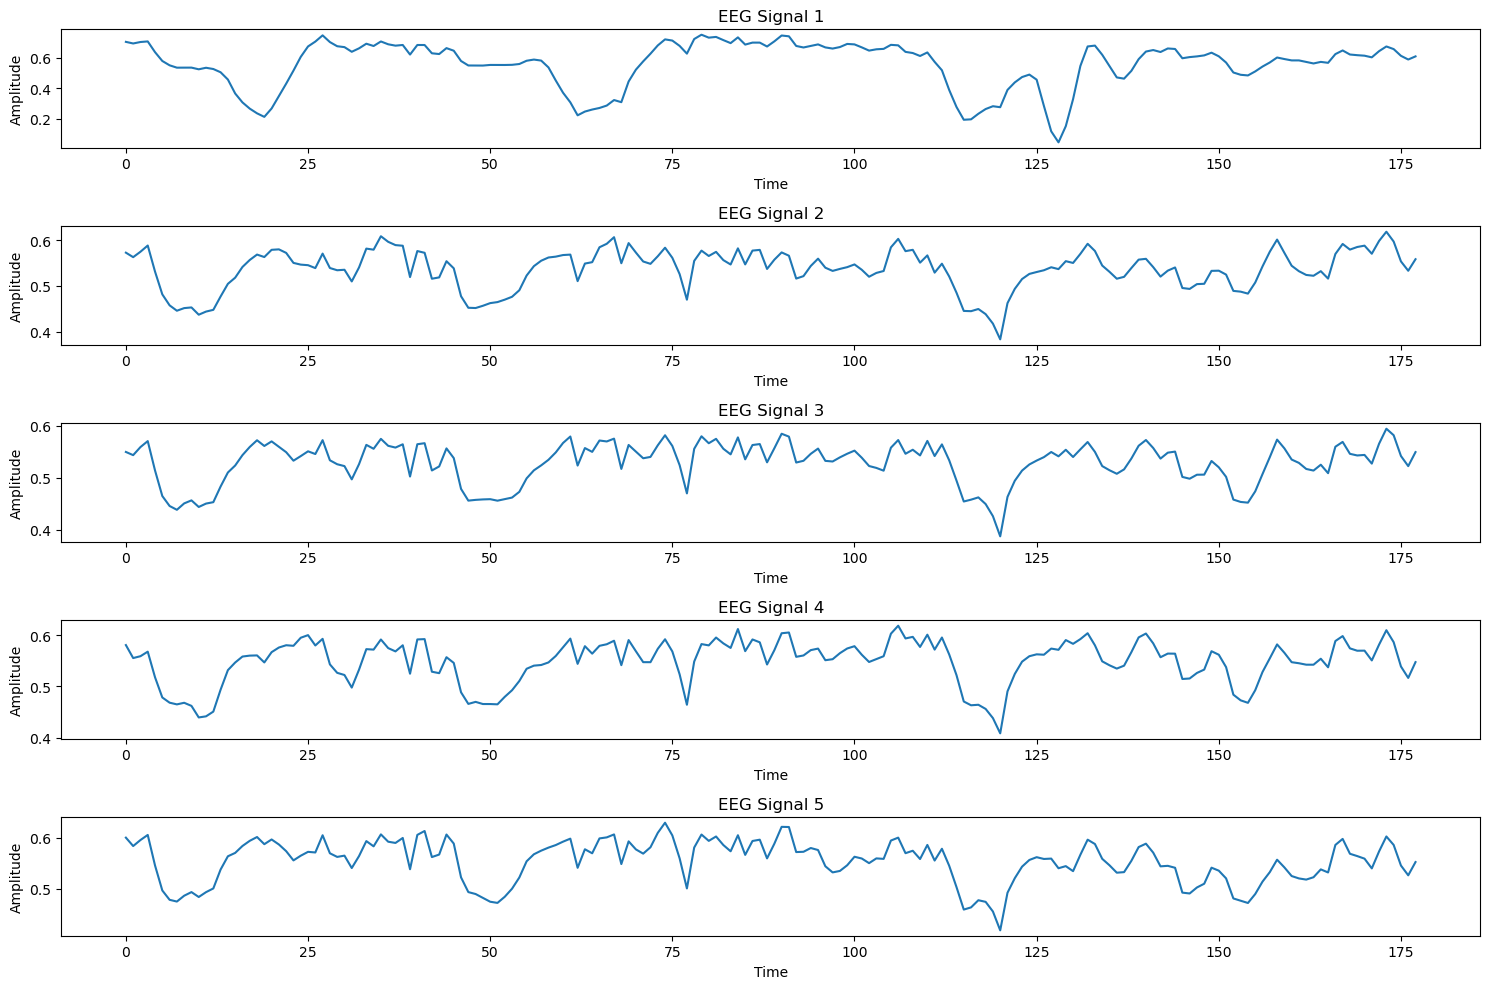

In [19]:
num_plots = 5  
plt.figure(figsize=(15, 10))

for i in range(num_plots):
    plt.subplot(num_plots, 1, i + 1)
    plt.plot(X_train_scaled[i])
    plt.title(f'EEG Signal {i + 1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

## Modeling

### Variatonal Auto Encorder

In [29]:

def InceptionNucleus(input_layer, filters, one_d_dropout_rate=0):
    branches = []
    for f in filters:
        x = Conv1D(
            filters=32,
            kernel_size=f,
            padding='same',
            activation='relu'
        )(input_layer)
        x = Dropout(one_d_dropout_rate)(x)
        branches.append(x)
    output = concatenate(branches, axis=-1)
    return output

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Encoder
input_shape = (178, 1)
latent_dim = 32 

inputs = Input(shape=input_shape, name='encoder_input')

x = InceptionNucleus(inputs, filters=[3, 5, 7], one_d_dropout_rate=0)
x = MaxPooling1D(pool_size=2)(x)  # Downsample by factor of 2
x = InceptionNucleus(x, filters=[3, 5, 7], one_d_dropout_rate=0)
x = MaxPooling1D(pool_size=2)(x)  # Downsample by another factor of 2

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

# Latent variables
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Sampling latent vector
z = Sampling()([z_mean, z_log_var])

# Define the encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(64, activation='relu')(latent_inputs)
x = Dense((178 // 4) * 96, activation='relu')(x)  
x = Reshape(((178 // 4), 96))(x)

x = Conv1DTranspose(
    filters=96,
    kernel_size=2,
    strides=2,
    padding='valid',
    activation='relu',
    output_padding=1  
)(x)

x = InceptionNucleus(x, filters=[3, 5, 7], one_d_dropout_rate=0)

x = Conv1DTranspose(
    filters=96,
    kernel_size=3,
    strides=2,
    padding='same',
    activation='relu'
)(x)  
x = InceptionNucleus(x, filters=[3, 5, 7], one_d_dropout_rate=0)

outputs = Conv1D(
    filters=1,
    kernel_size=1,
    activation='linear',
    padding='same',
    name='decoder_output'
)(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)

        # Compute reconstruction loss manually using Keras backend functions
        reconstruction_loss = K.mean(
            K.sum(
                K.square(inputs - reconstruction),
                axis=[1, 2]
            )
        )

        # Compute KL divergence loss using Keras backend functions
        kl_loss = -0.5 * K.mean(
            K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
        )

        # Weighting factor for the KL divergence loss
        beta = 0.4  

        # Total loss with beta weighting
        total_loss = reconstruction_loss + beta * kl_loss
        
        # Add losses to the model
        self.add_loss(total_loss)

        # Add metrics for monitoring
        # self.add_metric(reconstruction_loss, name='reconstruction_loss', aggregation='mean')
        # self.add_metric(kl_loss, name='kl_loss', aggregation='mean')

        return reconstruction
    
    def get_config(self):
        # Provide necessary information to reconstruct the model
        return {
            "encoder": self.encoder,
            "decoder": self.decoder,
        }

    @classmethod
    def from_config(cls, config):
        # Use the config dictionary to reconstruct the model
        return cls(**config)
    

# Instantiate and compile the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')


# Train the VAE
history  = vae.fit(
    X_train_scaled,
    epochs=250,
    batch_size=32,
    shuffle=True,
    validation_split=0.1
)



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 178, 1)]             0         []                            
                                                                                                  
 conv1d_24 (Conv1D)          (None, 178, 32)              128       ['encoder_input[0][0]']       
                                                                                                  
 conv1d_25 (Conv1D)          (None, 178, 32)              192       ['encoder_input[0][0]']       
                                                                                                  
 conv1d_26 (Conv1D)          (None, 178, 32)              256       ['encoder_input[0][0]']       
                                                                                            

#### Training Plots

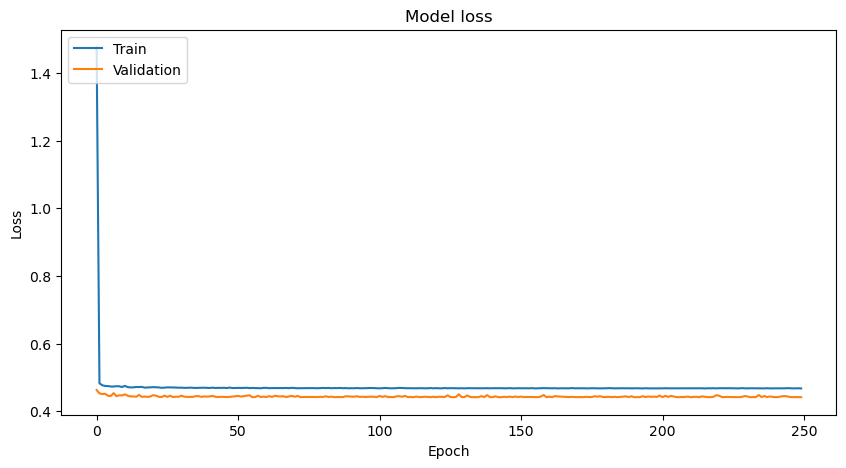

In [30]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Generating Synthetic Data

In [31]:
# Generate synthetic EEG data with broader sampling
num_synthetic_samples = 10
latent_samples = np.random.normal(
    loc=0.0,
    scale=2.0,  
    size=(num_synthetic_samples, latent_dim)
)
synthetic_eeg = decoder.predict(latent_samples)

1/1 [==============================] - 0s 200ms/step


In [32]:

# Check if all signals are the same
all_same = [np.array_equal(synthetic_eeg[0], signal) for signal in synthetic_eeg]

print(f"All signals are the same: {all_same}")

All signals are the same: [True, False, False, False, False, False, False, False, False, False]


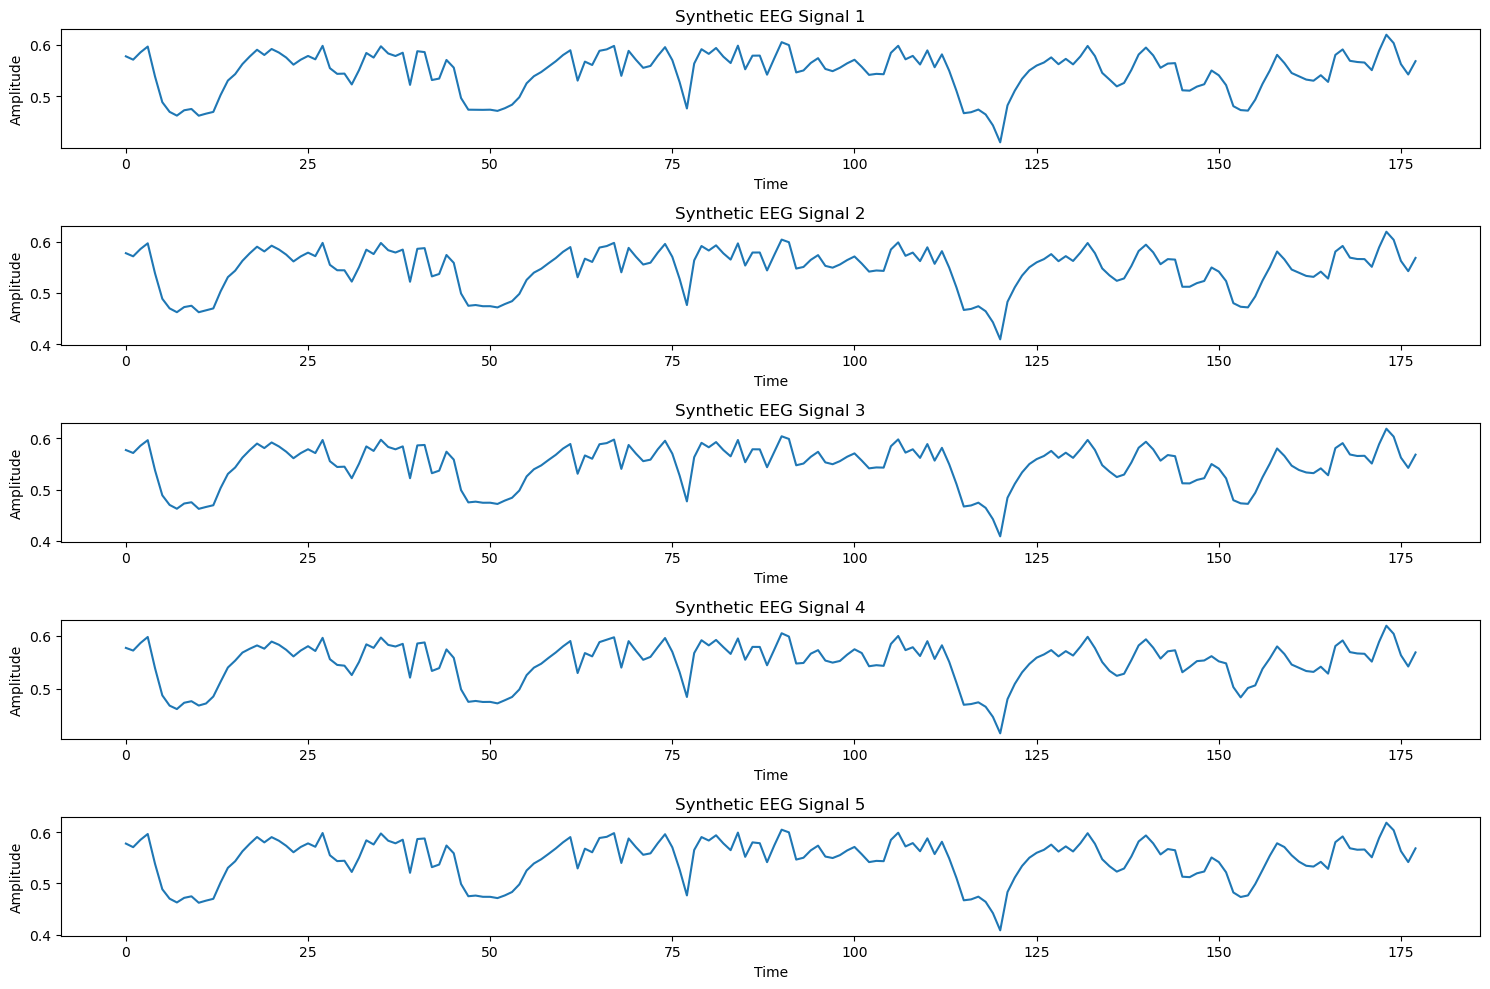

In [33]:
# Plot a few synthetic EEG signals
num_plots = 5  # Number of synthetic EEG signals to plot
plt.figure(figsize=(15, 10))

for i in range(num_plots):
    plt.subplot(num_plots, 1, i + 1)
    plt.plot(synthetic_eeg[i])
    plt.title(f'Synthetic EEG Signal {i + 1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

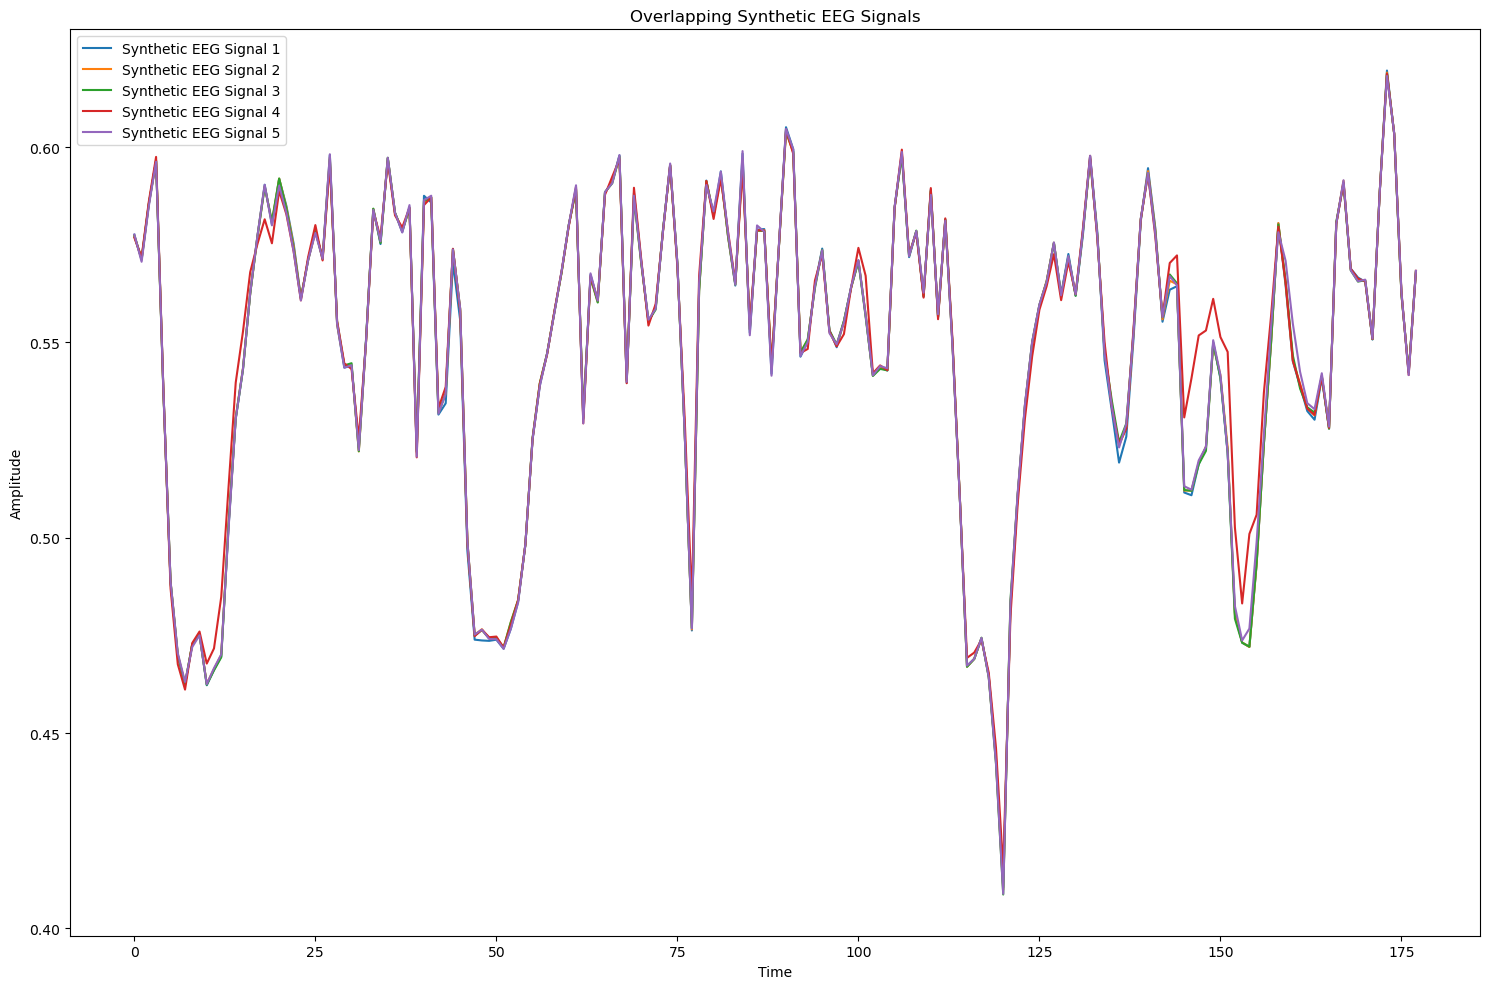

In [34]:
# Plot overlapping synthetic EEG signals
plt.figure(figsize=(15, 10))

for i in range(num_plots):
    plt.plot(synthetic_eeg[i], label=f'Synthetic EEG Signal {i + 1}')

plt.title('Overlapping Synthetic EEG Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()


#### Saving the model

In [ ]:
encoder.save('../models/VAE/encoder_model', save_format='tf')
decoder.save('../models/VAE/decoder_model', save_format='tf')
vae.save('../models/VAE/vae_model', save_format='tf')

INFO:tensorflow:Assets written to: ./models/VAE/encoder_model/assets


INFO:tensorflow:Assets written to: ./models/VAE/encoder_model/assets


INFO:tensorflow:Assets written to: ./models/VAE/decoder_model/assets


INFO:tensorflow:Assets written to: ./models/VAE/decoder_model/assets


INFO:tensorflow:Assets written to: ./models/VAE/vae_model/assets


INFO:tensorflow:Assets written to: ./models/VAE/vae_model/assets


### CVAE (Conditional Variational AutoEncorder)

#### Data

In [36]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data
train_data = pd.read_csv('../data/hard_test_cases/train.csv', index_col=0)
test_data = pd.read_csv('../data/hard_test_cases/test.csv', index_col=0)

# Separate features and labels
X_train = train_data.iloc[:, :-1].values  # Features X1-X178
y_train = train_data.iloc[:, -1].values   # Labels (0 for Non-Seizure, 1 for Seizure)

X_test = test_data.iloc[:, :-1].values    # Features X1-X178
y_test = test_data.iloc[:, -1].values     # Labels (0 for Non-Seizure, 1 for Seizure)

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for the model
X_train_scaled = X_train_scaled.reshape(-1, 178, 1)
X_test_scaled = X_test_scaled.reshape(-1, 178, 1)

# Prepare the labels for conditioning
# Ensure labels are integers for embedding
y_train = y_train.astype(int)
y_test = y_test.astype(int)



#### Modeling

In [37]:
def InceptionNucleus(input_layer, filters, one_d_dropout_rate=0):
    branches = []
    for f in filters:
        x = Conv1D(
            filters=32,
            kernel_size=f,
            padding='same',
            activation='relu'
        )(input_layer)
        x = Dropout(one_d_dropout_rate)(x)
        branches.append(x)
    output = concatenate(branches, axis=-1)
    return output

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Model parameters
input_shape = (178, 1)
latent_dim = 32 
num_classes = 2  # Two classes: Seizure and Non-Seizure

# Encoder
class_input = Input(shape=(1,), name='class_input')  # Class input for conditioning (0 or 1)
class_embedding = Embedding(input_dim=num_classes, output_dim=latent_dim)(class_input)
class_embedding = Flatten()(class_embedding)

inputs = Input(shape=input_shape, name='encoder_input')
x = InceptionNucleus(inputs, filters=[3, 5, 7], one_d_dropout_rate=0)
x = MaxPooling1D(pool_size=2)(x)
x = InceptionNucleus(x, filters=[3, 5, 7], one_d_dropout_rate=0)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

# Latent space
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Concatenate latent variables with class embedding
z_mean = concatenate([z_mean, class_embedding])
z_log_var = concatenate([z_log_var, class_embedding])

# Sampling latent vector
z = Sampling()([z_mean, z_log_var])

# Define the encoder model
encoder = Model([inputs, class_input], [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder
latent_inputs = Input(shape=(latent_dim + latent_dim,), name='z_sampling')  # Concatenated latent space and class
x = Dense(64, activation='relu')(latent_inputs)
x = Dense((178 // 4) * 96, activation='relu')(x)
x = Reshape(((178 // 4), 96))(x)

x = Conv1DTranspose(
    filters=96,
    kernel_size=2,
    strides=2,
    padding='valid',
    activation='relu',
    output_padding=1
)(x)
x = InceptionNucleus(x, filters=[3, 5, 7], one_d_dropout_rate=0)
x = Conv1DTranspose(
    filters=96,
    kernel_size=3,
    strides=2,
    padding='same',
    activation='relu'
)(x)
x = InceptionNucleus(x, filters=[3, 5, 7], one_d_dropout_rate=0)

outputs = Conv1D(
    filters=1,
    kernel_size=1,
    activation='linear',
    padding='same',
    name='decoder_output'
)(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

class CVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        x, class_label = inputs  # Unpack inputs and class labels
        z_mean, z_log_var, z = self.encoder([x, class_label])  # Pass both data and class label
        reconstruction = self.decoder(z)

        # Compute reconstruction loss
        reconstruction_loss = K.mean(
            K.sum(
                K.square(x - reconstruction),
                axis=[1, 2]
            )
        )
        
        # Compute KL divergence loss
        kl_loss = -0.5 * K.mean(
            K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
        )

        # Weighting factor for the KL divergence loss
        beta = 0.4
        total_loss = reconstruction_loss + beta * kl_loss
        self.add_loss(total_loss)

        return reconstruction
    
    def get_config(self):
        # Provide necessary information to reconstruct the model
        return {
            "encoder": self.encoder,
            "decoder": self.decoder,
        }

    @classmethod
    def from_config(cls, config):
        # Use the config dictionary to reconstruct the model
        return cls(**config)

# Instantiate and compile the CVAE
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer='adam')

# Assuming X_train_scaled is your input data and y_train is the one-hot encoded class labels
history = cvae.fit(
    [X_train_scaled, y_train],
    epochs=250,
    batch_size=32,
    shuffle=True,
    validation_split=0.1
)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 178, 1)]             0         []                            
                                                                                                  
 conv1d_36 (Conv1D)          (None, 178, 32)              128       ['encoder_input[0][0]']       
                                                                                                  
 conv1d_37 (Conv1D)          (None, 178, 32)              192       ['encoder_input[0][0]']       
                                                                                                  
 conv1d_38 (Conv1D)          (None, 178, 32)              256       ['encoder_input[0][0]']       
                                                                                            

#### Save the model

In [38]:
encoder.save('../models/CVAE/cvae_encoder_model', save_format='tf')
decoder.save('../models/CVAE/cvae_decoder_model', save_format='tf')
cvae.save('../models/CVAE/cvae_model', save_format='tf')

# The class_embedding_model is a standalone model created using the embedding layers from the encoder. You might want to save this separately for use in embedding class labels independently of the CVAE model.
class_embedding_model = Model(inputs=class_input, outputs=class_embedding) 
class_embedding_model.save('../models/CVAE/class_embedding_model', save_format='tf')

INFO:tensorflow:Assets written to: ../models/CVAE/cvae_encoder_model/assets


INFO:tensorflow:Assets written to: ../models/CVAE/cvae_encoder_model/assets


INFO:tensorflow:Assets written to: ../models/CVAE/cvae_decoder_model/assets


INFO:tensorflow:Assets written to: ../models/CVAE/cvae_decoder_model/assets


INFO:tensorflow:Assets written to: ../models/CVAE/cvae_model/assets


INFO:tensorflow:Assets written to: ../models/CVAE/cvae_model/assets


INFO:tensorflow:Assets written to: ../models/CVAE/class_embedding_model/assets


INFO:tensorflow:Assets written to: ../models/CVAE/class_embedding_model/assets


In [ ]:
embedded_class_labels = class_embedding_model.predict(np.array([[1]] * 1))  # Shape (n_samples, latent_dim)

1/1 [==============================] - 0s 22ms/step


#### Sythetic Data Generation

In [39]:
def generate_synthetic_data(class_value, n_samples=1):
    # Prepare the class labels array as input, repeating it n_samples times
    class_label_input = np.array([[class_value]] * n_samples)  # Shape (n_samples, 1)

    # Embed the class labels using the same embedding layer as in the encoder
    # class_embedding_model = Model(inputs=class_input, outputs=class_embedding)  # Reuse the embedding part of encoder
    embedded_class_labels = class_embedding_model.predict(class_label_input)  # Shape (n_samples, latent_dim)

    # Generate random samples from the latent space with randomness each time
    latent_samples = np.random.normal(loc=0, scale=3, size=(n_samples, latent_dim))  # Shape (n_samples, latent_dim)

    # Concatenate latent samples with embedded class labels
    latent_samples_with_class = np.concatenate([latent_samples, embedded_class_labels], axis=-1)  # Shape (n_samples, latent_dim + latent_dim)

    # Generate synthetic data using the decoder
    synthetic_data = decoder.predict(latent_samples_with_class)  # Shape (n_samples, 178, 1)
    return synthetic_data

# Example usage
synthetic_seizure_data = generate_synthetic_data(1,5)  # Generate data for Seizure class
synthetic_non_seizure_data = generate_synthetic_data(0,5)  # Generate data for Non-Seizure class


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 20ms/step


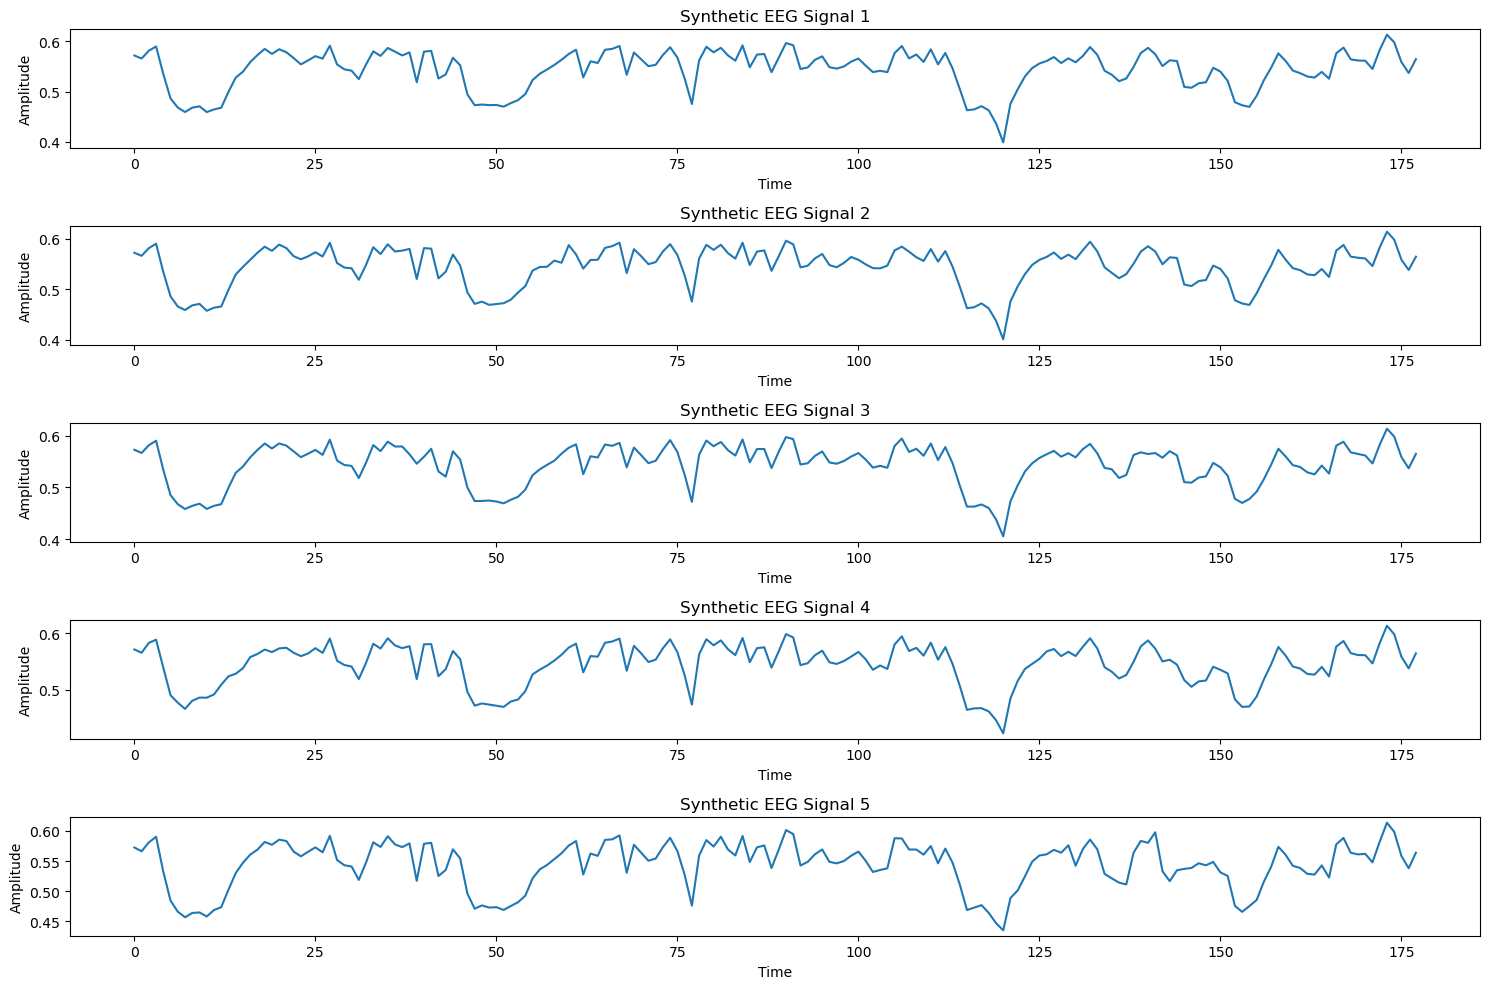

In [40]:
# Plot a few synthetic EEG signals
num_plots = 5  # Number of synthetic EEG signals to plot
plt.figure(figsize=(15, 10))

for i in range(num_plots):
    plt.subplot(num_plots, 1, i + 1)
    plt.plot(synthetic_seizure_data[i])
    plt.title(f'Synthetic EEG Signal {i + 1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

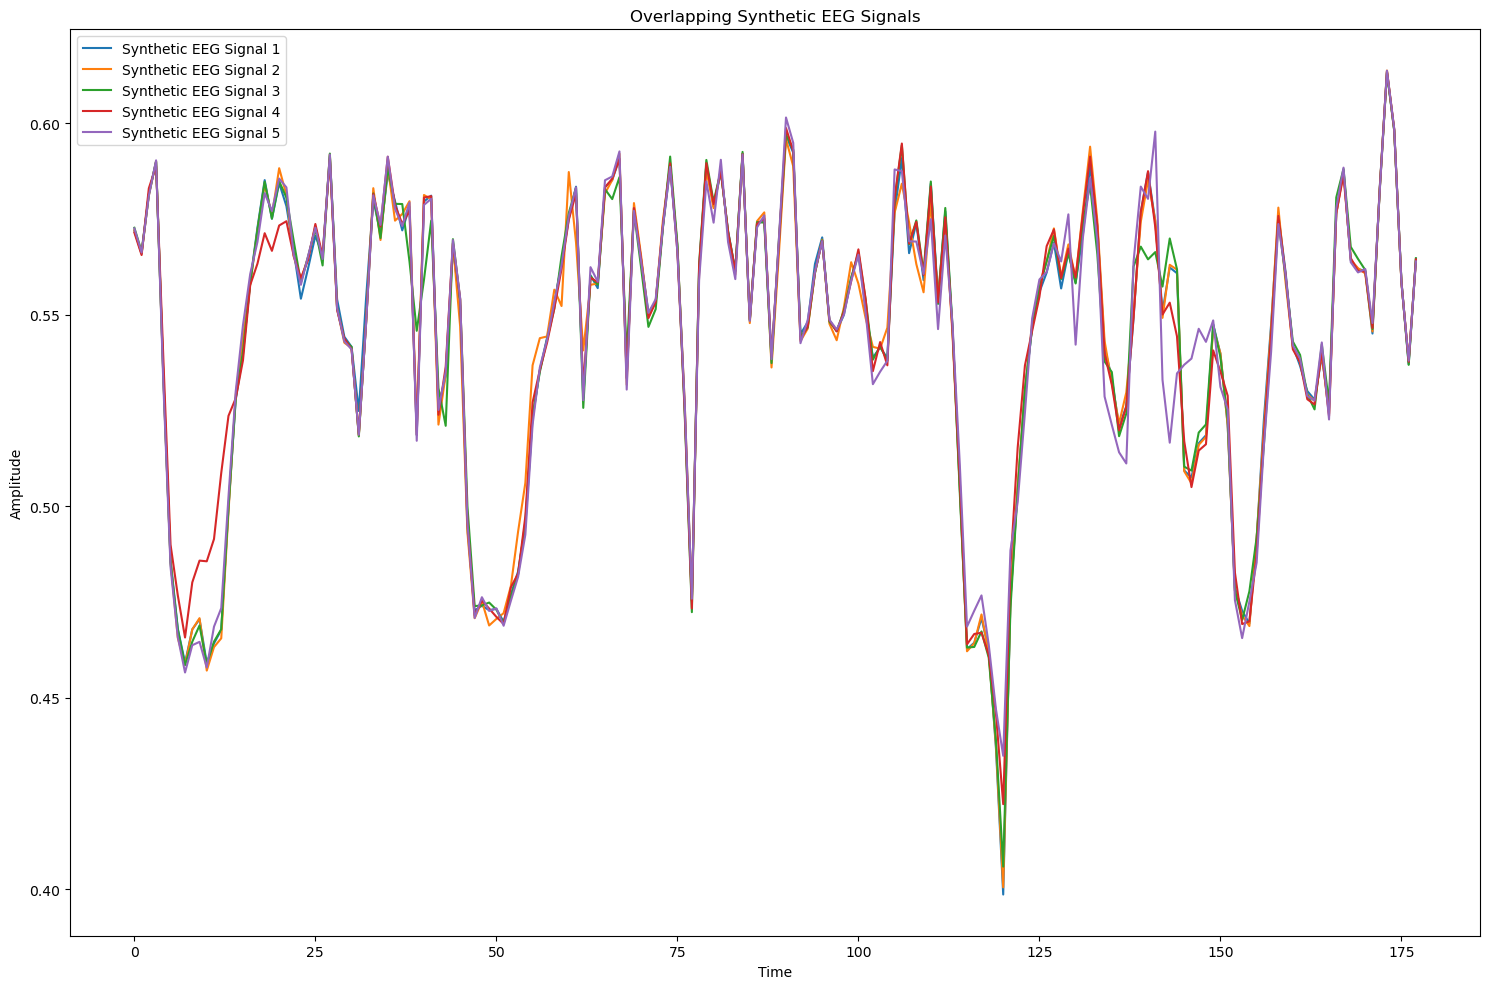

In [41]:
# Plot overlapping synthetic EEG signals
plt.figure(figsize=(15, 10))

for i in range(num_plots):
    plt.plot(synthetic_seizure_data[i], label=f'Synthetic EEG Signal {i + 1}')

plt.title('Overlapping Synthetic EEG Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()


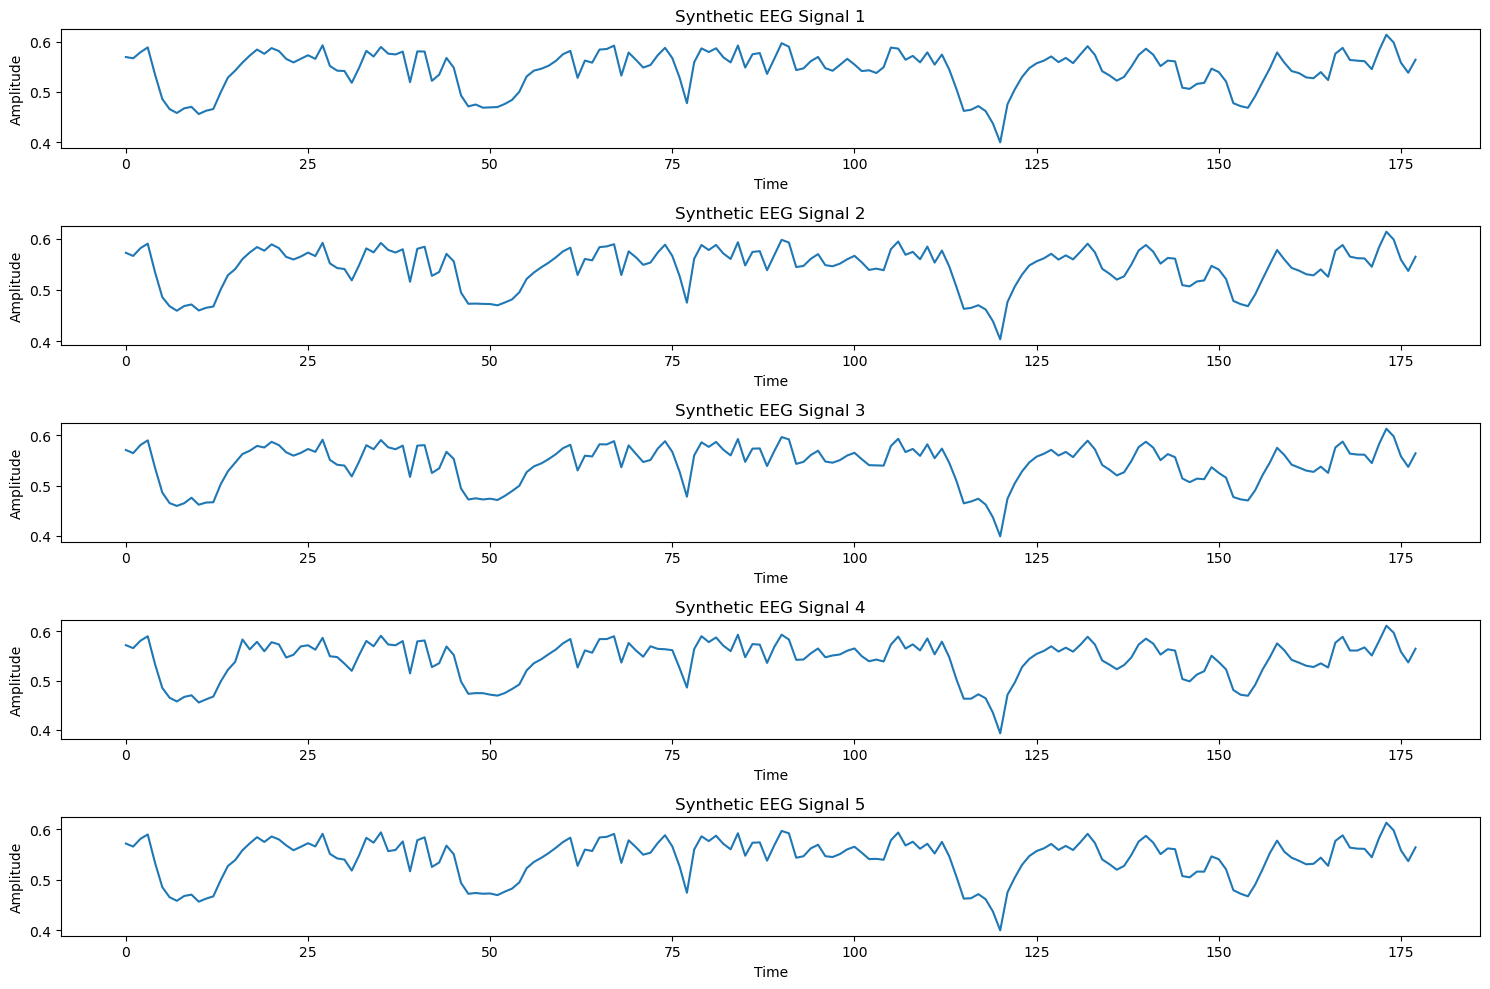

In [42]:
# Plot a few synthetic EEG signals
num_plots = 5  # Number of synthetic EEG signals to plot
plt.figure(figsize=(15, 10))

for i in range(num_plots):
    plt.subplot(num_plots, 1, i + 1)
    plt.plot(synthetic_non_seizure_data[i])
    plt.title(f'Synthetic EEG Signal {i + 1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

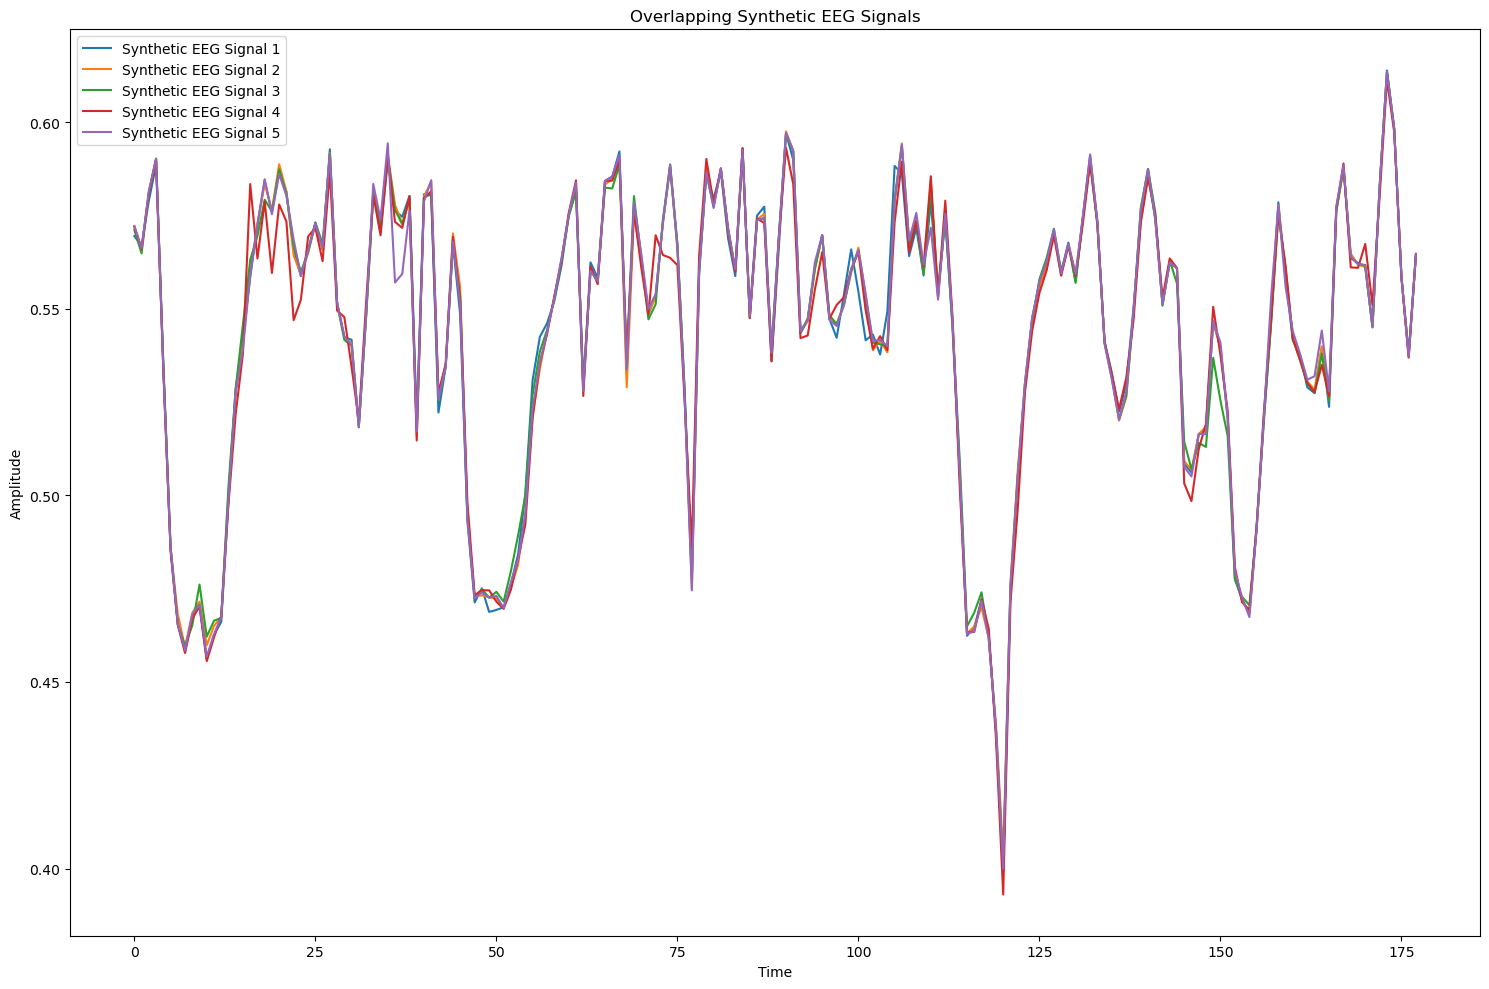

In [43]:
# Plot overlapping synthetic EEG signals
plt.figure(figsize=(15, 10))

for i in range(num_plots):
    plt.plot(synthetic_non_seizure_data[i], label=f'Synthetic EEG Signal {i + 1}')

plt.title('Overlapping Synthetic EEG Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()


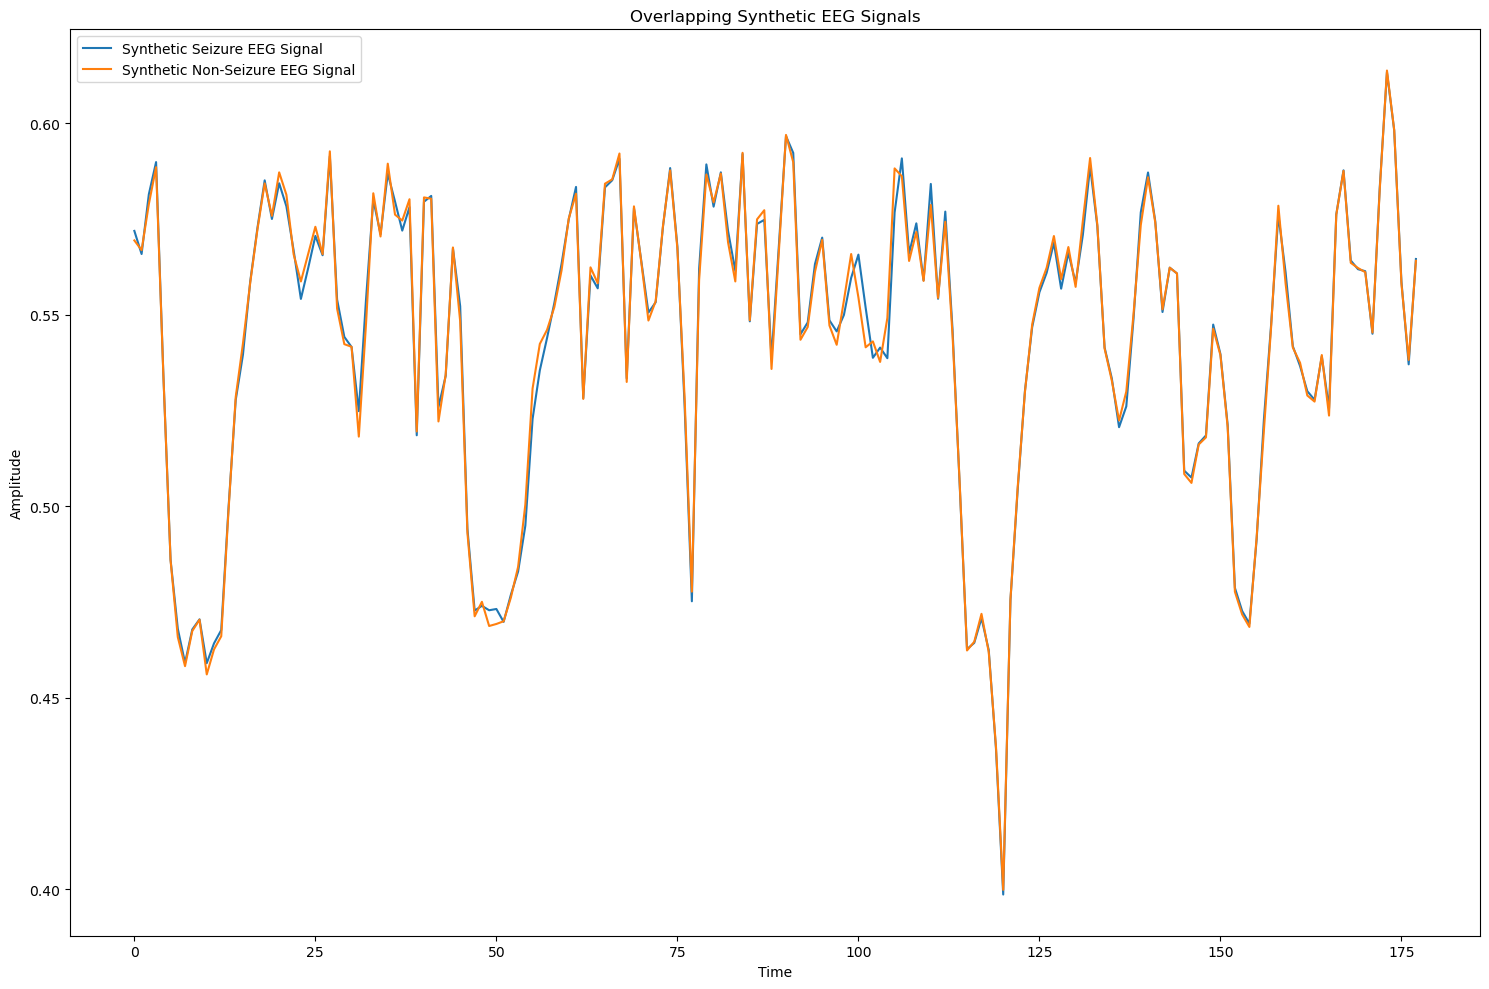

In [44]:
# Plot overlapping synthetic EEG signals for one seizure and one non-seizure
plt.figure(figsize=(15, 10))

plt.plot(synthetic_seizure_data[0], label='Synthetic Seizure EEG Signal')
plt.plot(synthetic_non_seizure_data[0], label='Synthetic Non-Seizure EEG Signal')

plt.title('Overlapping Synthetic EEG Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

## Vizualization of Latent Space

320/320 [==============================] - 1s 2ms/step


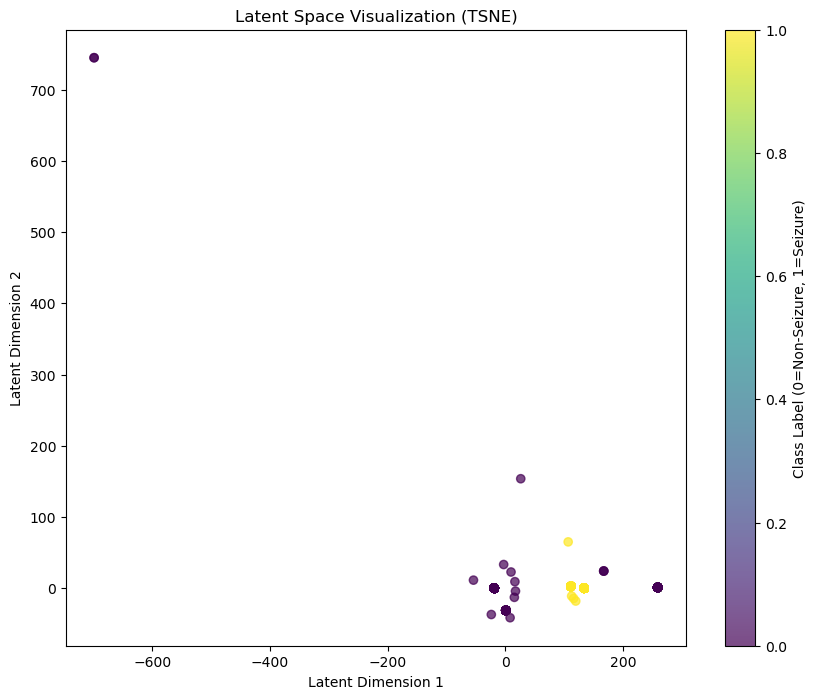

In [45]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Function to visualize latent space
def visualize_latent_space(encoder, data, labels, method='pca'):
    """
    Visualize the latent space of the VAE.
    
    Parameters:
    - encoder: Trained encoder model
    - data: Input data to be encoded
    - labels: True labels of the data (e.g., Seizure or Non-Seizure)
    - method: 'pca' or 'tsne' for dimensionality reduction
    """
    # Get latent representations (z_mean) from the encoder
    z_mean, _, _ = encoder.predict([data, labels])  # Get the mean latent representation

    # Reduce to 2D using PCA or t-SNE
    if method == 'pca':
        z_reduced = PCA(n_components=2).fit_transform(z_mean)
    elif method == 'tsne':
        z_reduced = TSNE(n_components=2).fit_transform(z_mean)
    else:
        raise ValueError("Invalid method. Use 'pca' or 'tsne'.")

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.scatter(z_reduced[:, 0], z_reduced[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(label='Class Label (0=Non-Seizure, 1=Seizure)')
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title(f"Latent Space Visualization ({method.upper()})")
    plt.show()

# Example usage with training data
visualize_latent_space(encoder, X_train_scaled, y_train, method='tsne')
